In [1]:
import sys
import networkx as nx
import numpy as np
import random
from collections import defaultdict
import torch
import math
import importlib
import pandas as pd
#torch.set_num_threads(1)

sys.path.insert(0, '../../')
import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers



In [2]:
%matplotlib inline

# Sherrington Kirkpatrick

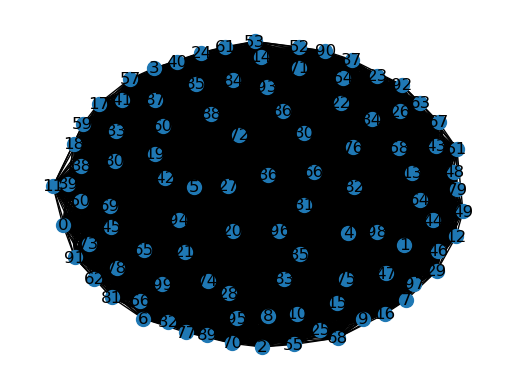

In [56]:
import importlib
import matplotlib.pyplot as plt
import random
seed=4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
N = 100
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))
J_sigma_val=1
J_0_val=0
if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)

J_prob = graph_gen.spin_glass(N, J = J_sigma_val, J_0 = J_0_val)
J = graph_gen.set_J(J_interaction, J_prob)
#J = (J + J.transpose())
#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.
Th. results

In [57]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

device="cpu"
#device="mps"
SK_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=2
beta_init = 0.1
step = 39
betas = np.linspace(beta_init, beta_fin, step)

stats_step=1

In [58]:
from python_lib.models import spins_model
importlib.reload(spins_model)

SK_model_exact = spins_model.model(N, H, J, J_interaction, device="cpu")
f_exact = []
f_exact_infN = []
steps = 0
for beta_ in betas:
    if steps % stats_step == 0:
        f_exact.append(SK_model_exact.exact(beta_))
    steps += 1


AssertionError: 

# MonteCarlo sampler

 999.0 / 1000tensor([98., 96., 94.,  ..., 14., 14., 14.])


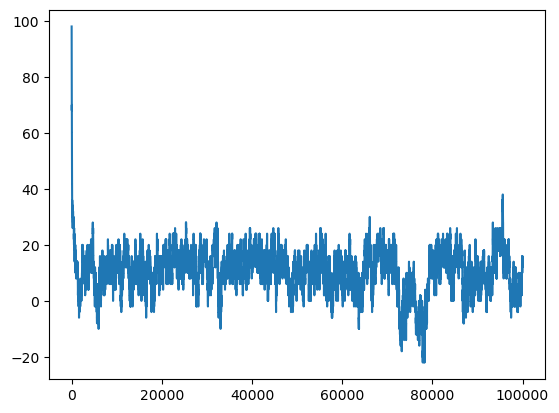

In [59]:
import torch
import numpy as np

# Define the number of spins
num_spins = N

# Define the interaction strength between the spins
#J = torch.randn((num_spins, num_spins))

# Define the external magnetic field strength
#h = torch.randn((num_spins))

# Define the temperature (beta)
beta = 2
J=torch.Tensor(J)
h=torch.Tensor(H)
# Define the initial state
initial_state = torch.randint(2, (num_spins,), dtype=J.dtype) * 2 - 1

# Define the number of MCMC steps
num_swap = 1000
num_steps = num_swap * N

# Define the current state
current_state = initial_state

# Define the time correlation array
time_correlation = torch.zeros((num_steps,))

all_states = torch.zeros((num_swap, num_spins))
initial_energy = -torch.dot(initial_state, torch.matmul(J, initial_state)) - torch.dot(initial_state, h)

# Loop over the number of MCMC steps
for i in range(num_steps):
    # Choose a random spin to flip
    flip_index = torch.randint(num_spins, (1,))
    proposal_state = current_state.clone().detach()
    proposal_state[flip_index] = -proposal_state[flip_index]

    # Calculate the energy difference between the proposal state and the current state
    energy_diff = -torch.dot(proposal_state, torch.matmul(J, proposal_state)) - torch.dot(proposal_state, h) + torch.dot(current_state, torch.matmul(J, current_state)) + torch.dot(current_state, h)

    #inter = -((samples @ self.J).view(m, 1, self.N) @ samples.view(m, self.N, 1)).squeeze()
    #field = -(samples.view(m, 1, self.N) @ self.H.view(self.N, 1)).squeeze()


    # Calculate the acceptance probability
    acceptance_prob = torch.min(torch.tensor([1.0]), torch.exp(-beta * energy_diff))

    # Generate a random number between 0 and 1
    random_number = torch.rand(1)

    # Decide whether to accept or reject the proposal state
    if random_number < acceptance_prob:
        current_state = proposal_state
    else:
        current_state = current_state

    # Compute the time correlation
    time_correlation[i] = torch.dot(current_state, initial_state)
    
    if i % N == 0:
        all_states[int(i/N)] = current_state
        print(f"\r {i/N} / {num_swap}", end="")
# Print the time correlation array
print(time_correlation)
import matplotlib.pyplot as plt
plt.plot(time_correlation)


In [60]:
all_states.shape

torch.Size([1000, 100])

In [61]:
num_taus = 200
time_correlation = torch.zeros((num_taus,))
for taus in range(1, num_taus):
    print(f"\r {taus} / {num_taus}", end="")
    norm_T=0
    for i in range(num_swap):
        if i + taus < num_swap:
            time_correlation[taus] += torch.dot(all_states[i], all_states[i+taus])
            norm_T += 1
        else:
            time_correlation[taus] /= (norm_T*N)
            break

 199 / 200

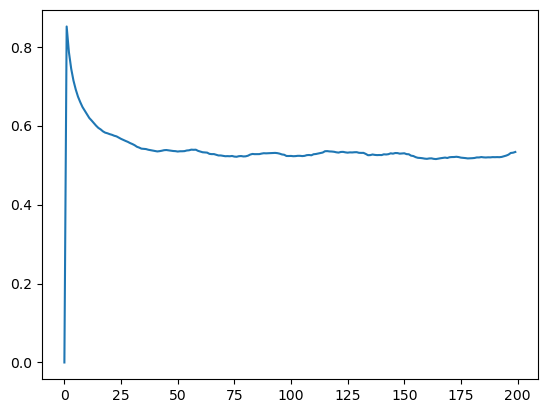

In [62]:
import matplotlib.pyplot as plt
plt.plot(time_correlation)

In [237]:
import torch
import numpy as np

# Define the number of spins
num_spins = N

# Define the interaction strength between the spins
#J = torch.randn((num_spins, num_spins))

# Define the external magnetic field strength
#h = torch.randn((num_spins))

# Define the temperature (beta)
beta = 2
J=torch.Tensor(J)
h=torch.Tensor(H)
# Define the initial state
m = 200
num_sample=10000
sample_every_swap=200
num_swap = sample_every_swap * num_sample / m
initial_state = torch.randint(2, (m, num_spins), dtype=J.dtype) * 2 - 1


# Define the number of MCMC steps
num_steps = num_swap * N

# Define the current state
current_state = initial_state

# Define the time correlation array
#time_correlation = torch.zeros((num_steps,))

all_states = torch.zeros((int(num_sample/m),m, num_spins))

# Loop over the number of MCMC steps
for swap_ in range(int(num_swap)):
    for i in range(N):
    # Choose a random spin to flip
        flip_index = torch.randint(num_spins, (m,))
        proposal_state = current_state.clone().detach()
        proposal_state[:,flip_index] = -proposal_state[:,flip_index]

        # Calculate the energy difference between the proposal state and the current state
        inter_curr = -(
                (current_state @ J).view(m, 1, N) @ current_state.view(m, N, 1)
            ).squeeze()
        field_curr = -(current_state.view(m, 1, N) @
                    H.view(N, 1)).squeeze()
        inter_prop = -(
                (proposal_state @ J).view(m, 1, N) @ proposal_state.view(m, N, 1)
            ).squeeze()
        field_prop = -(proposal_state.view(m, 1, N) @
                    H.view(N, 1)).squeeze()

        energy_diff = - inter_curr + field_curr + (inter_prop + field_prop)

        #inter = -((samples @ self.J).view(m, 1, self.N) @ samples.view(m, self.N, 1)).squeeze()
        #field = -(samples.view(m, 1, self.N) @ self.H.view(self.N, 1)).squeeze()


        # Calculate the acceptance probability
        acceptance_prob = torch.min(torch.tensor(m*[1.0]), torch.exp(-beta * energy_diff))

        # Generate a random number between 0 and 1
        random_number = torch.rand(m)

        # Decide whether to accept or reject the proposal state
        current_state = torch.where((random_number < acceptance_prob).unsqueeze(dim=1), proposal_state, current_state)

        # Compute the time correlation
        #time_correlation[i] = torch.dot(current_state, initial_state)
        
    if swap_ % sample_every_swap == 0:
        all_states[int(swap_/sample_every_swap)] = current_state
    print(f"\r {swap_} / {num_swap}", end="")
# Print the time correlation array
#print(time_correlation)
#import matplotlib.pyplot as plt
#plt.plot(time_correlation)


 9999 / 10000.0

In [238]:
all_states.mean()

tensor(-0.0013)

# Train net

In [239]:
import python_lib.nets.ann
importlib.reload(python_lib.nets.ann)

from python_lib.nets import h2net
importlib.reload(h2net)
from python_lib import run_lib
importlib.reload(run_lib);

In [240]:
lr = 0.001
max_step = 1000
batch_size=2000
std_fe_limit=1e-4
batch_iter=20
stats_step=1
batch_fraction=2

In [241]:
J_not = graph_gen.set_J(J_interaction, J_prob)
J_not = J_not/np.sqrt(N)
SK_model_not = spins_model.model(N, H, J_not, J_interaction, device=device)



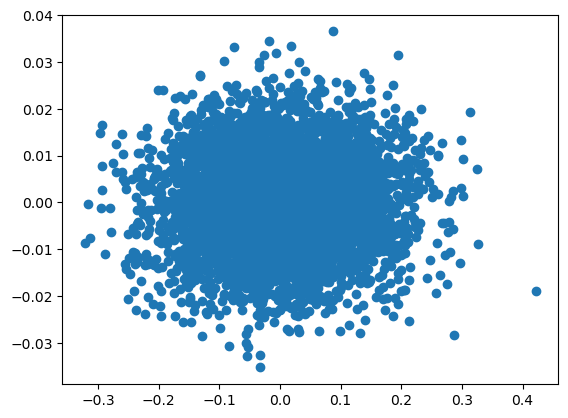

In [242]:
plt.plot(J.detach().numpy().flatten(), SK_model_not.J.flatten(), "o")

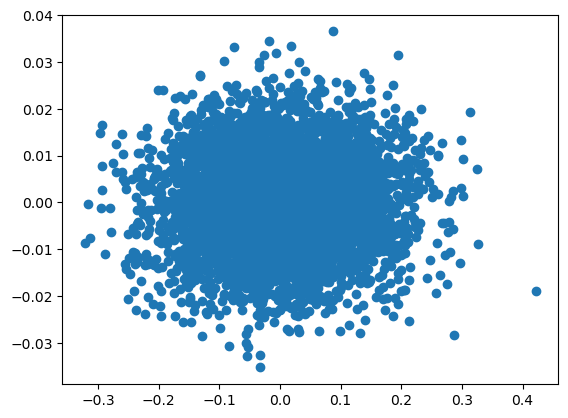

In [243]:
plt.plot(J.detach().numpy().flatten(), SK_model_not.J.flatten(), "o")

In [244]:
list_n = h2net.SK_net_krsb
learn = True
dict_nets = {"k": 1, "set_exact": learn}
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
net = h2net.list_nets(
    SK_model, list_n, input_mask, device=device, dict_nets=dict_nets, learn_first_l=learn)
list_n.learn_first_l = learn
net.set_params_first_l(SK_model_not)



Total Trainable Params: 59700
Total Params: 59700


In [245]:
for name, param in net.named_parameters():
        print(name, param.size())

J torch.Size([100, 100])


In [246]:
for name, param in net.net[0].named_parameters():
        print(name, param.size())

weight_p torch.Size([3, 99])
bias_p torch.Size([2, 99])
weight_m torch.Size([3, 99])
bias_m torch.Size([2, 99])
weight_0 torch.Size([1])
bias_0 torch.Size([1])


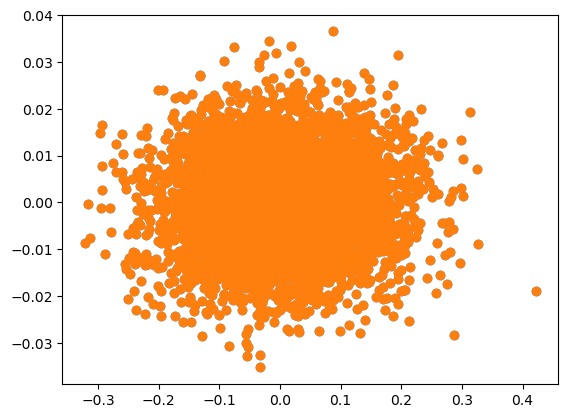

In [247]:
plt.plot(J.detach().numpy().flatten(), net.J.detach().numpy().flatten(), "o")

plt.plot(J.detach().numpy().flatten(), J_not.flatten(), "o")

In [248]:
samples = all_states.view(-1, N)

step: 119 2.00000 fe: -0.378 +- 0.07172 E: -0.035, S: 0.687, M: 0.0808 sample_t : 0.0 log_prob : 0.69 loss : 1.3 optimizer : 0.62 stats : 0.13.113

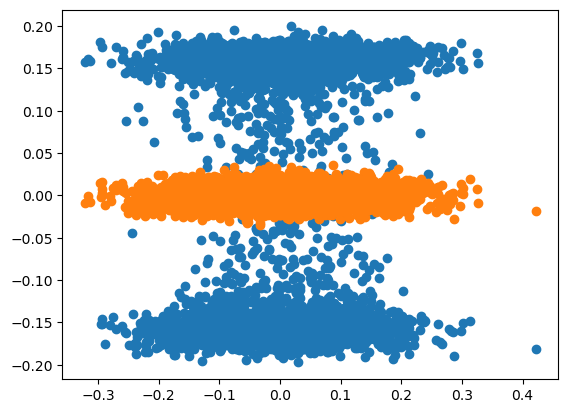

In [249]:
import matplotlib.pyplot as plt

stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=100,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta,
                            batch_fraction=batch_fraction,
                            )
plt.plot(J.detach().numpy().flatten(), net.J.detach().numpy().flatten(), "o")

plt.plot(J.detach().numpy().flatten(), J_not.flatten(), "o")

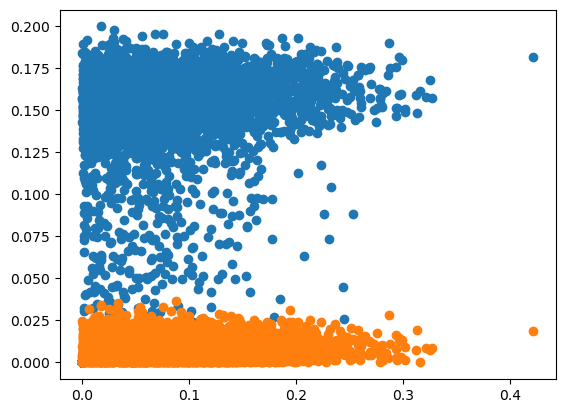

In [250]:
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(J_not.flatten()), "o")

step: 319 2.00000 fe: -0.662 +- 0.04576 E: -0.438, S: 0.448, M: 0.0968 sample_t : 1.2e-06 log_prob : 0.7 loss : 1.3 optimizer : 0.66 stats : 0.1227

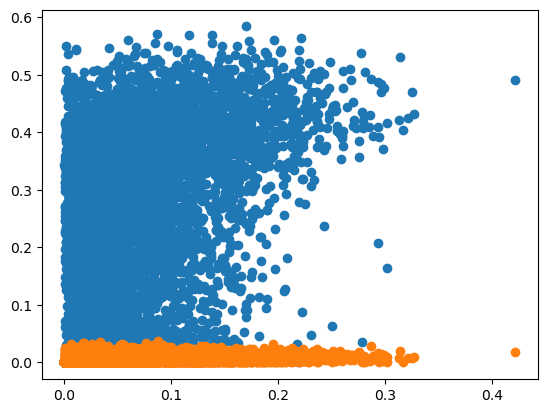

In [251]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=300,
                            batch_fraction=batch_fraction,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(J_not.flatten()), "o")

step: 1019 2.00000 fe: -0.710 +- 0.02474 E: -0.538, S: 0.345, M: 0.0979 sample_t : 0.0 log_prob : 0.68 loss : 1.1 optimizer : 0.56 stats : 0.1 0.199

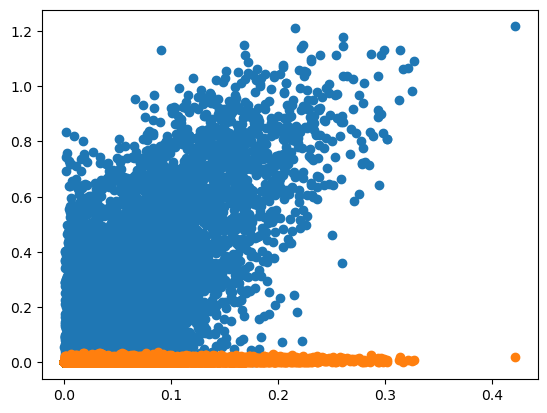

In [252]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=1000,
                            batch_fraction=batch_fraction,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(J_not.flatten()), "o")

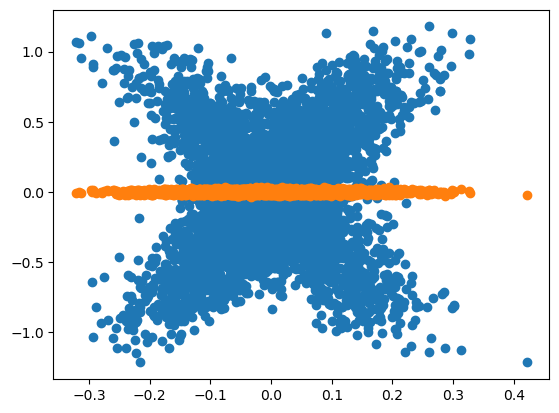

In [253]:
import matplotlib.pyplot as plt
plt.plot(J.detach().numpy().flatten(), net.J.detach().numpy().flatten(), "o")

plt.plot(J.detach().numpy().flatten(), J_not.flatten(), "o")

In [254]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=2000,
                            batch_fraction=batch_fraction,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(J_not.flatten()), "o")

step: 200 2.00000 fe: -0.709 +- 0.02634 E: -0.536, S: 0.346, M: 0.0994 sample_t : 9.5e-07 log_prob : 0.83 loss : 1.3 optimizer : 0.76 stats : 0.111

KeyboardInterrupt: 

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0051,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0500, -0.0996,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[-0.2797, -0.0829,  0.0627,  ...,  0.0858,  0.0000,  0.0000],
         [-0.2797, -0.0829,  0.0627,  ...,  0.0858,  0.0000,  0.0000]],

        [[-0.2797, -0.0829,  0.0627,  ...,  0.0858,  0.0000,  0.0000],
         [ 0.0769,  0.0120, -0.1771,  ...,  0.0044, -0.1435,  0.0000]],

        [[ 0.0769,  0.0120, -0.1771,  ...,  0.0044, -0.1435,  0.0000],
         [ 0.0769,  0.0120, -0.1771,  ...,  0.0044, -0.1435,  0.0000]]])

[0.03908757 3.64293473]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 1.809e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:46:47   Log-Likelihood:                 4501.4
No. Observations:               10000   AIC:                            -8999.
Df Residuals:                    9998   BIC:                            -8984.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0391      0

<AxesSubplot:>

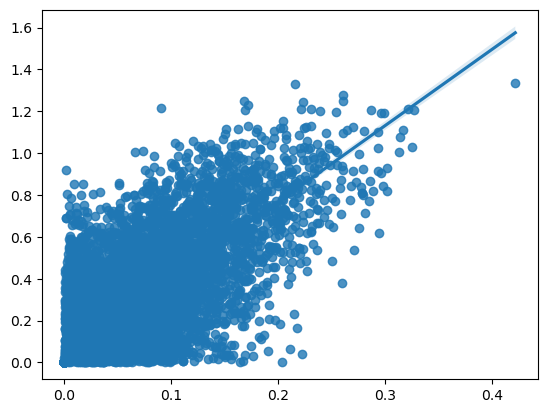

In [271]:
import seaborn as sns
import statsmodels.api as sm

y = np.abs(net.J.detach().numpy().flatten())
x = np.abs(J.detach().numpy().flatten())

model = sm.OLS(y, sm.add_constant(x))
results = model.fit()

print(results.params)
# const        10.603498 <- intercept
# education     0.594859 <- slope
# dtype: float64

print(results.summary())
sns.regplot(x=x, y=y)


<AxesSubplot:>

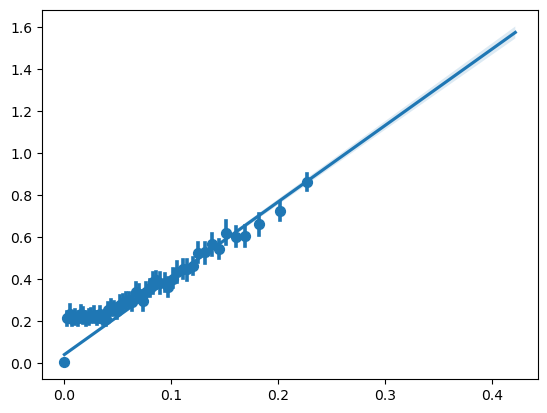

In [280]:
sns.regplot(x=x, y=y, x_bins=100)


(0.0, 1.0)

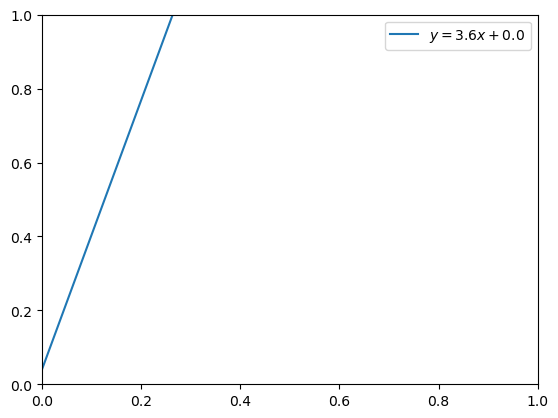

In [277]:
import matplotlib.pyplot as plt

# extract intercept b and slope m
b, m = results.params

# plot y = m*x + b
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 1)

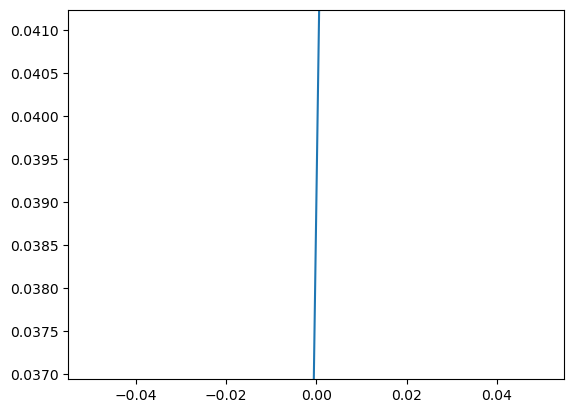

In [272]:
from scipy import stats

m, b, *_ = stats.linregress(x, y)
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')


step: 1019 2.00000 fe: -0.709 +- 0.02485 E: -0.541, S: 0.336, M: 0.0882 sample_t : 0.0 log_prob : 0.12 loss : 0.33 optimizer : 0.15 stats : 0.00190154

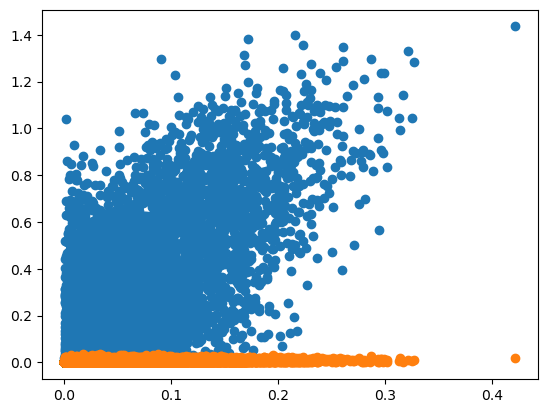

In [281]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=1000,
                            batch_fraction=20,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(J_not.flatten()), "o")

[0.04128887 3.74397073]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                 1.719e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:08:20   Log-Likelihood:                 3973.6
No. Observations:               10000   AIC:                            -7943.
Df Residuals:                    9998   BIC:                            -7929.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0413      0

<AxesSubplot:>

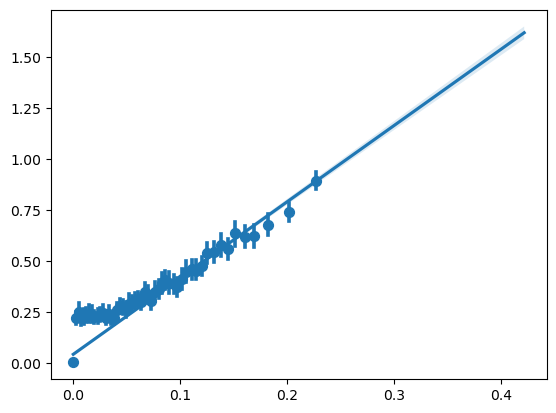

In [283]:
import seaborn as sns
import statsmodels.api as sm

y = np.abs(net.J.detach().numpy().flatten())
x = np.abs(J.detach().numpy().flatten())

model = sm.OLS(y, sm.add_constant(x))
results = model.fit()

print(results.params)
# const        10.603498 <- intercept
# education     0.594859 <- slope
# dtype: float64

print(results.summary())
sns.regplot(x=x, y=y, x_bins=100)


In [284]:
np.savez("MC_data/data.npz", J=J.detach().numpy(), J_not=J_not, net=net.J.detach().numpy(), samples=samples, lr=lr, max_step=max_step, batch_fraction=batch_fraction, std_fe_limit=std_fe_limit, batch_iter=batch_iter, beta=beta)

In [184]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=1000,
                            batch_size=batch_size,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().numpy().flatten()), np.abs(J_not.flatten()), "o")

TypeError: ANN.train_with_samples() got an unexpected keyword argument 'batch_size'

# Theoretical Values
at zero temperature
K0 S=-0.16 U=-0.798 
K1 S=-0.01 U=-0.7653 
K2 S=-0.004 U=-0.7636 

In [24]:
data_exact = pd.DataFrame(f_exact)
data = data_exact

In [25]:
data.plot(x="beta", y= "free_energy_mean",)


KeyError: 'beta'

# Several cases

In [26]:
from python_lib.nets import list_nets
importlib.reload(list_nets)
import python_lib.nets.ann
importlib.reload(python_lib.nets.ann)
from python_lib import run_lib
importlib.reload(run_lib);

In [27]:
lr = 0.001
max_step = 1000
batch_size=2000
std_fe_limit=1e-4
batch_iter=20
stats_step=1

In [28]:
from python_lib.nets import ann
importlib.reload(ann)

from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net_krsb_one
learn=False
one.learn_first_l= learn
one.set_params_exact(SK_model, betas[0])
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"k": 0, "set_exact": learn}
net2train = list_nets.list_nets(SK_model, one, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SK_net_0rs",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 15050
Total Params: 15050
step: 883 0.35000 fe: -2.063 +- 0.00172 E: -0.163, S: 0.665, M: 0.0808 sample_t : 0.13 log_prob : 0.12 loss : 0.00044 optimizer : 0.087 stats : 0.012Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ocadni/opt/anaconda3/envs/m1torch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_26955/2794536490.py", line 15, in <cell line: 15>
    res = run_lib.train_net(net2train, betas,
  File "/Users/ocadni/git/pytorch_test/results/SK/../../python_lib/run_lib.py", line 31, in train_net
    ss = net2train.train(
  File "/Users/ocadni/git/pytorch_test/results/SK/../../python_lib/nets/list_nets.py", line 644, in train
    def __init__(
  File "/Users/ocadni/git/pytorch_test/results/SK/../../python_lib/nets/ann.py", line 196, in train
    samples, x_hat = self.sample(batch_size)
  File "/Users/ocadni/git/pytorch_test/results/SK/../../python_lib/nets/list_nets.py", line 622, in sample
    weight_0 = torch.zeros((1), device=device, dtype=dtype)
  File "/Users/ocadni/opt/anaconda3/envs/m1torch

In [12]:
from python_lib.nets import ann
importlib.reload(ann)

from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net_krsb
learn=False
one.learn_first_l= learn
one.set_params_exact(SK_model, betas[0])
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"k": 2, "set_exact": learn}
net2train = list_nets.list_nets(SK_model, one, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SK_net_0rs",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 69500
Total Params: 69500
step: 2 0.10000 fe: -6.929 +- 0.07477 E: -0.001, S: 0.693, M: 0.0824 sample_t : 0.25 log_prob : 0.29 loss : 0.00033 optimizer : 0.22 stats : 0.0097

KeyboardInterrupt: 

In [11]:
net2train.num_params()

29900

In [23]:
aa = net2train.net[2].named_parameters()
for k, pp in aa:
    print(k, pp.shape)

weight_p torch.Size([2, 97])
bias_p torch.Size([1, 97])
weight_m torch.Size([2, 97])
bias_m torch.Size([1, 97])
weight_0 torch.Size([1])
bias_0 torch.Size([1])


In [16]:
aa

[Parameter containing:
 tensor([[-9.4142e-03,  1.2632e-02, -1.8377e-03,  1.5051e-03,  1.0750e-03,
          -2.7803e-03, -2.6021e-02,  6.2446e-03, -8.6836e-03, -2.0506e-03,
           3.9756e-03,  6.6993e-03, -5.3707e-04,  4.6695e-04, -1.7671e-02,
          -2.1205e-02,  1.5191e-02, -6.6820e-03,  3.0777e-05, -1.5355e-03,
           1.1396e-02, -2.3019e-03,  1.1877e-02,  7.6774e-03, -7.5883e-03,
          -1.8534e-03, -8.5579e-03, -2.3464e-03, -4.2153e-03,  8.4884e-03,
          -6.7758e-03, -9.4454e-03, -4.8154e-03,  1.2434e-02,  2.3693e-02,
           2.8294e-03, -2.3454e-03,  1.6892e-02,  2.7164e-03, -1.3655e-03,
          -6.9479e-03, -1.3186e-02, -9.6939e-03,  6.4025e-03,  8.2012e-03,
          -9.1511e-03, -2.1437e-02,  1.4072e-02, -2.6317e-04,  2.7204e-02,
          -5.9554e-03,  9.8715e-03,  1.0861e-02,  6.0981e-04,  4.1661e-04,
           6.7826e-03, -8.9515e-03, -1.0143e-02, -2.4286e-03, -1.5727e-02,
           1.3940e-02, -1.9406e-03,  4.8184e-05, -1.3165e-02,  2.0401e-04,
  

In [11]:
from python_lib.nets import ann
importlib.reload(ann)

from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net_krsb
learn=False
one.learn_first_l= learn
one.set_params_exact(SK_model, 0)
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"k": 1, "set_exact": learn}
net2train = list_nets.list_nets(SK_model, one, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SK_net_1rs",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 49700
Total Params: 49700


RuntimeError: [srcBuf length] > 0 INTERNAL ASSERT FAILED at "/Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/native/mps/OperationUtils.mm":242, please report a bug to PyTorch. Placeholder tensor is empty!

In [ ]:
from python_lib.nets import ann
importlib.reload(ann)

from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net_rs
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"set_exact": False}
net2train = list_nets.list_nets(SK_model, one, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SK_net_rs",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 26
Total Params: 26
step: 75 2.00000 fe: -0.461 +- 0.00006 E: -0.197, S: 0.529, M: 0.382 sample_t : 0.00077 log_prob : 0.00064 loss : 0.00014 optimizer : 0.00076 stats : 0.01545

In [ ]:
from python_lib.nets import ann
importlib.reload(ann)

from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net_rs
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"set_exact": True}
net2train = list_nets.list_nets(SK_model, one, input_mask, device=device, dict_nets=dict_nets)
#[nnn.set_params_first_l(SK_model) for nnn in net2train.net]
net2train.set_params_exact(SK_model, betas[0])
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SK_net_rs_set",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 22
Total Params: 26
step: 144 0.10000 fe: -6.861 +- 0.62758 E: 0.032, S: 0.689, M: 0.514

KeyboardInterrupt: 

In [13]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(SK_model, bias=True, device=device)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 10100
Total Params: 10100
step: 22 0.10000 fe: -6.651 +- 0.23488 E: -0.008, S: 0.664, M: 0.0771 sample_t : 0.084 log_prob : 0.0015 loss : 0.00027 optimizer : 0.0014 stats : 0.00879

KeyboardInterrupt: 

In [14]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(SK_model, 
    bias=True, 
    device=device,
    net_depth=2,
    net_width=1
)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE_21",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 20300
Total Params: 20300
step: 19 0.10000 fe: -6.905 +- 0.09745 E: -0.005, S: 0.690, M: 0.0822 sample_t : 0.13 log_prob : 0.002 loss : 0.00033 optimizer : 0.0028 stats : 0.00871

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [15]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(SK_model, 
    bias=True, 
    device=device,
    net_depth=2,
    net_width=2
)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE_22",
    batch_iter=batch_iter,
    stats_step=stats_step
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 40500
Total Params: 40500
step: 14 0.10000 fe: -6.908 +- 0.09362 E: -0.009, S: 0.690, M: 0.0798 sample_t : 0.12 log_prob : 0.0019 loss : 0.00031 optimizer : 0.0033 stats : 0.009

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
data["beta"] = betas

In [ ]:
name_nets=["_SK_net_0rs", "_SK_net_1rs", "_SK_net_rs", "_SK_net_rs_set", "_MADE", "_MADE_21", "_MADE_22", ]

for kk in name_nets:
    data[f"err_fe{kk}"] = np.abs(data[f"free_energy_mean{kk}"] - data["free_energy_mean"])
    data[f"err_fe{kk}_rel"] = np.abs((data[f"err_fe{kk}"] / data["free_energy_mean"]))


In [54]:
data.to_csv(f"data/SK_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}_max_iter{max_step}_beta_step{step}.zip")

In [55]:
data = pd.read_csv(f"data/SK_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}_max_iter{max_step}_beta_step{step}.zip")

<AxesSubplot:xlabel='beta'>

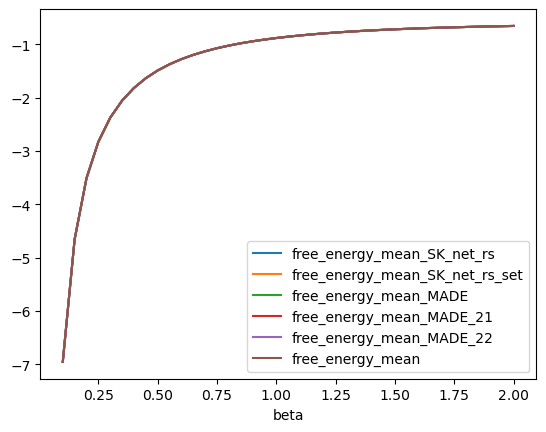

In [57]:
kkk="free_energy_mean"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy_mean")
data.plot(x="beta", y=namess)


<AxesSubplot:xlabel='beta'>

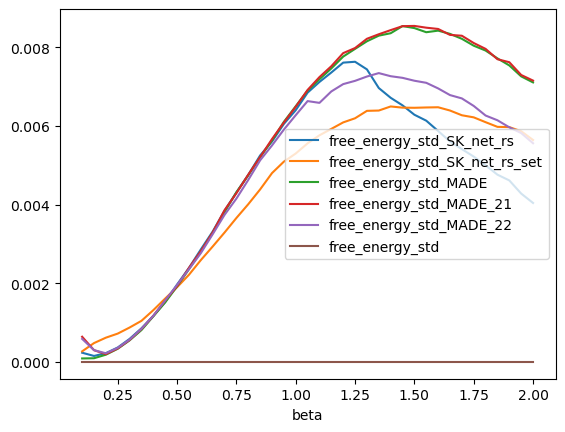

In [58]:
kkk="free_energy_std"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

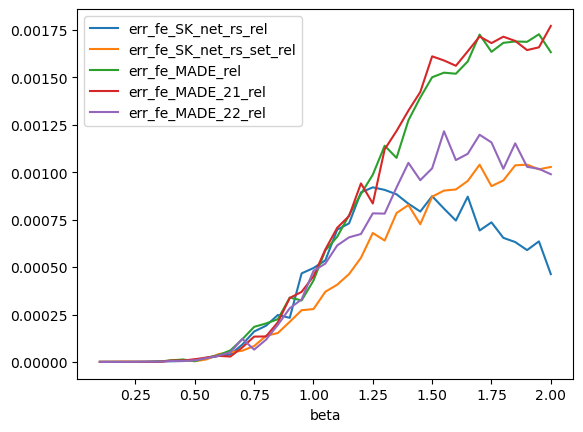

In [59]:
namess=[f"err_fe{x}_rel" for x in name_nets]
#namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

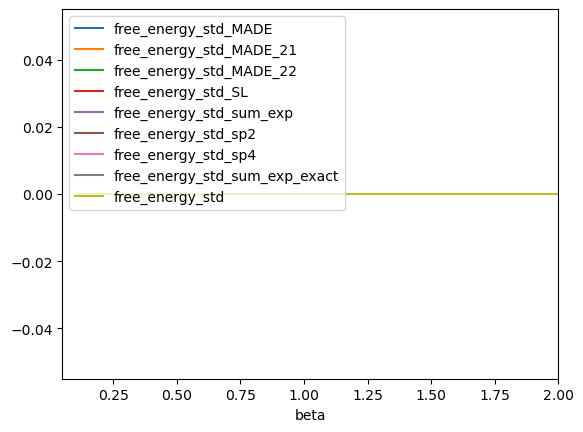

In [ ]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
kkk="free_energy_std"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy_std")
data[data["beta"]> 0.1].plot(x="beta", y=namess, xlim=(0.05,2))

<AxesSubplot:xlabel='beta'>

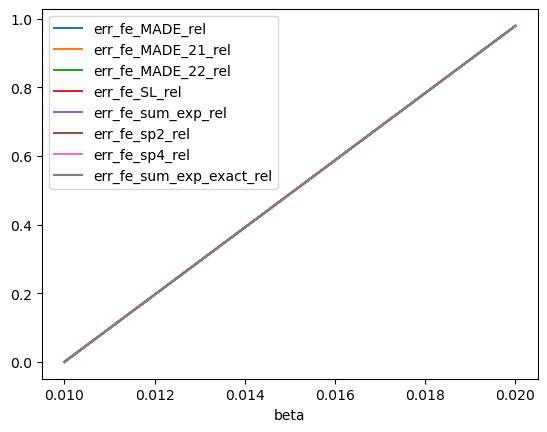

In [ ]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}_rel" for x in name_nets]
#namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

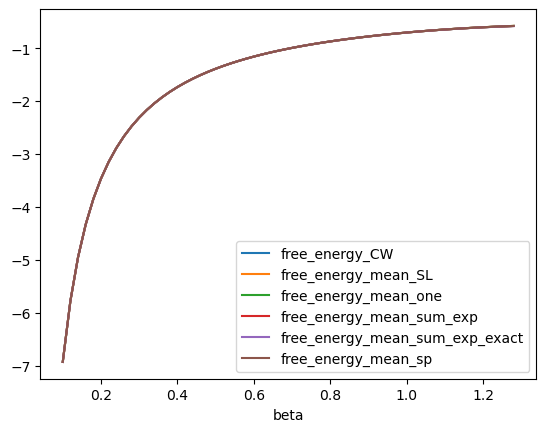

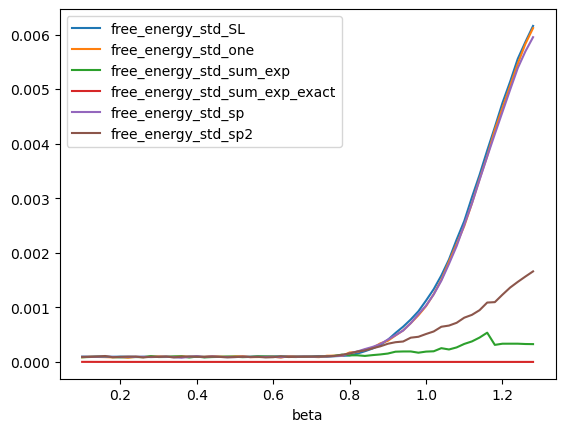

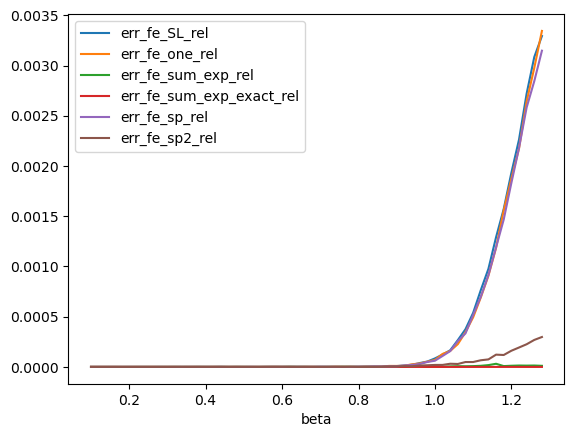

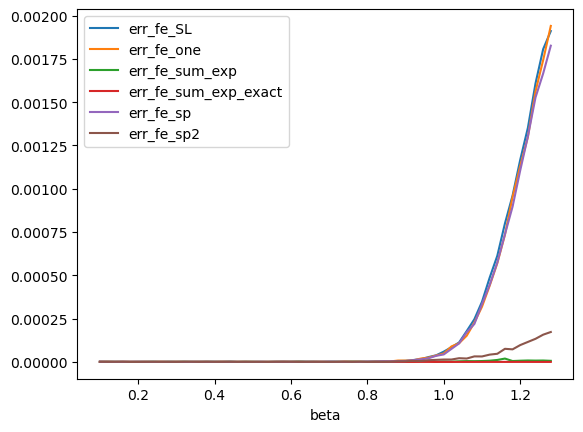

In [ ]:

data.plot(x="beta", y=["free_energy_std_SL", "free_energy_std_one", "free_energy_std_sum_exp", "free_energy_std_sum_exp_exact","free_energy_std_sp","free_energy_std_sp2",]) #"free_energy_std_sp4"])
data.plot(x="beta", y=["err_fe_SL_rel", "err_fe_one_rel", "err_fe_sum_exp_rel", "err_fe_sum_exp_exact_rel","err_fe_sp_rel","err_fe_sp2_rel"])#,"err_fe_sp4_rel"])
data.plot(x="beta", y=["err_fe_SL", "err_fe_one", "err_fe_sum_exp", "err_fe_sum_exp_exact", "err_fe_sp", "err_fe_sp2"])# "err_fe_sp4"])

In [ ]:
data.plot(x="beta", y=["mag_mean", "mag_mean_CW", "mag_mean_SL", "mag_mean_one", "mag_mean_sum_exp", "mag_mean_sum_exp_exact"])


KeyError: "['mag_mean'] not in index"

In [ ]:
data.plot(x="beta", y=["entropy_mean", "entropy_mean_SL", "entropy_mean_1V", "entropy_mean_SK", "entropy_mean_SK_exact"])


KeyError: "['entropy_mean', 'entropy_mean_1V', 'entropy_mean_SK', 'entropy_mean_SK_exact'] not in index"

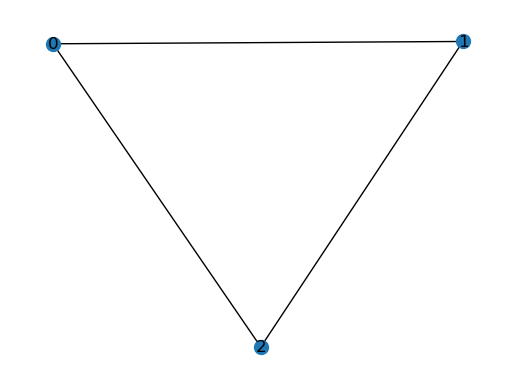

In [ ]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

N = 3
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))

if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)
JJ=1
J_val = JJ/(2*N)
J = J_val * J_interaction


device="cpu"
#device="mps"
CW_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=1.3
beta_init = 0.1
step = 0.1
betas = np.arange(beta_init, beta_fin
, step)

In [ ]:
from python_lib.nets import ann
importlib.reload(ann)
from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.long()
dict_nets = {}
net2train = list_nets.list_nets(CW_model, one, input_mask, device=device, dict_nets=dict_nets)

In [ ]:
beta = 1
net2train.train(
    beta=beta,
    lr=lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit = 0.001,
    exact=True
)


step: 0 1.00 fe: -0.594 +- 0.24724 E: 0.069, S: 0.662, M: 0.397

{'beta': 1,
 'free_energy_mean': -0.5935537020365397,
 'free_energy_std': 0.2472420334815979,
 'entropy_mean': 0.6624425649642944,
 'energy_mean': 0.06888888776302338,
 'mag': array([ 0.001, -0.008,  0.034], dtype=float32),
 'mag_mean': 0.3966667056083679}

In [ ]:
x, hx=net2train.sample(200000)
torch.abs(x.mean(-1)).mean(), x.mean(-1).mean()

(tensor(0.3982), tensor(0.0010))

In [ ]:
i = 0
for nnet in net2train.net:
    print(f"ni: {i}")
    i+=1
    for name, param in nnet.named_parameters():
        print(name, param.data)


ni: 0
weight_p tensor([[ 0.3333,  0.0000, -0.3333]])
bias_p tensor([[1.0000, 0.6931, 0.3333]])
weight_m tensor([[ 0.3333,  0.0000, -0.3333]])
bias_m tensor([[0.3333, 0.6931, 1.0000]])
weight_0p tensor([1.])
weight_0m tensor([-1.])
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])
ni: 1
weight_p tensor([[ 0.1667, -0.1667]])
bias_p tensor([[0.3333, 0.0000]])
weight_m tensor([[ 0.1667, -0.1667]])
bias_m tensor([[0.0000, 0.3333]])
weight_0p tensor([1.])
weight_0m tensor([-1.])
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])
ni: 2
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])


In [ ]:
m = x.sum(-1)
m

tensor([ 2., -6.])

In [ ]:
weight_p = torch.tensor([[1,2,3,4]], device=device)

In [ ]:
weight_p

tensor([[1, 2, 3, 4]])

In [ ]:
res = weight_p * torch.unsqueeze(m, dim=1)
res

tensor([[  2.,   4.,   6.,   8.],
        [ -6., -12., -18., -24.]])

In [ ]:
torch.logsumexp(res, 1)

tensor([ 8.1451, -5.9975])

In [ ]:
pd.__version__

In [ ]:
data.plot(x="beta", y=["free_energy_std_SL", "free_energy_std_1V"], ylim=(0, 0.1))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
stats_pd.plot.line(x="beta", y="energy_mean")

In [ ]:
stats_pd.plot.line(x="beta", y="energy_mean")

In [ ]:
all_Js = np.array(all_Js)

In [ ]:
plt.plot(stats_pd["beta"], all_Js[:,2])
plt.plot(stats_pd["beta"], all_Js[:,3])
plt.plot(stats_pd["beta"], all_Js[:,4])
plt.plot(stats_pd["beta"], all_Js[:,5])
plt.plot(stats_pd["beta"], all_Js[:,19])

In [ ]:
import pandas as pd

lr = 0.001
max_step=1000
batch_size=1000
stats = []
net2train = net
for beta in betas:
    net2train.train(
        beta=beta,
        lr=lr,
        max_step=max_step,
        batch_size=batch_size,
        std_fe_limit = 0.001
    )

    stats.append(net.compute_stats(
        beta, batch_size=batch_size, print_=True))
stats_pd = pd.DataFrame(stats)

In [ ]:
from python_lib.nets import simplest
from python_lib.solvers import train_nn_anneal
importlib.reload(simplest)
importlib.reload(solvers)
bias = True
net_simplest = simplest.simplest(CW_model.N, CW_model, bias, device=device)

In [ ]:
from python_lib.nets import one_var
importlib.reload(one_var)
bias = True
net_one_var = one_var.one_var(CW_model.N, CW_model, bias, device=device)

In [ ]:
from python_lib.solvers import train_nn_anneal
importlib.reload(simple_layer)
importlib.reload(solvers)
import pandas as pd

lr = 0.001
max_step=1000
batch_size=1000
stats = []
net2train = net_one_var
for beta in betas:
    net2train.train(
        beta=beta,
        lr=lr,
        max_step=max_step,
        batch_size=batch_size,
        std_fe_limit = 0.001
    )

    stats.append(net.compute_stats(
        beta, batch_size=batch_size, print_=True))
stats_pd = pd.DataFrame(stats)

In [ ]:
stats_pd_est = pd.DataFrame(stats)
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd_est["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,0.)

ax1.plot(betas, np.abs(f_exact-stats_pd_est["free_energy_mean"])/np.abs(f_exact))
ax1.plot(betas, np.abs(f_exact-stats_pd_est["free_energy_mean"]))
    
ax2.plot(stats_pd_est["free_energy_std"])

In [ ]:
net_simplest.layer1.weight

In [ ]:
from python_lib.solvers import train_nn_anneal
importlib.reload(simple_layer)
importlib.reload(solvers)
import pandas as pd

lr = 0.001
max_step=100
batch_size=2000
stats = train_nn_anneal(
    net, 
    np.full(100, 0.0001),
    lr=lr, 
    max_step=5,
    batch_size=batch_size)
stats = train_nn_anneal(
    net, 
    betas,
    lr=lr, 
    max_step=max_step,
    batch_size=batch_size)
stats_pd = pd.DataFrame(stats)

In [ ]:
stats_pd = pd.DataFrame(stats)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,-0.6)

ax1.plot(betas, np.abs(f_exact-stats_pd["free_energy_mean"])/np.abs(f_exact))
    
ax2.plot(stats_pd["free_energy_std"])

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,-0.6)

ax1.plot(betas, np.abs(f_exact-stats_pd["free_energy_mean"]))
    
ax2.plot(stats_pd["free_energy_std"])

In [ ]:
stats_pd.keys()

In [ ]:
stats_pd[stats_pd["beta"]==0.2]

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(2,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(np.linspace(0.001,beta,100), f_exact)
ax0.set_ylim(-1.25,-0.7)

for b in np.linspace(0.001,beta,100):
    
err = [np.abs()]

In [ ]:
net.compute_stats(beta, batch_size=50000)

## random case

In [ ]:
from python_lib.nets import bp_nn
importlib.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.001, 
           max_step=1000,
               opt="adam")


In [ ]:
net_rand.compute_stat_is(beta, batch_size=10000)

# BP solution

In [ ]:
import bp_solver
importlib.reload(bp_solver)

bp_sol = bp_solver.BP_solver(tree_rand)

In [ ]:
beta

In [ ]:
bp_sol.converge(beta)